## Caustic Projection Lamp -- A Lamp That Is More Lamp

### Evan Zhang, Carrie Wang


## Scene setup

In [ ]:
import os
from os.path import realpath, join, isfile
import numpy as np
import drjit as dr
import mitsuba as mi

# mi.set_variant('llvm_ad_rgb')
mi.set_variant('cuda_ad_rgb')

SCENE_DIR = realpath('/home/yz864/4197/scenes')

CONFIGS = {
    'example': {
        'emitter':         'bayer',
        'reference_front': join(SCENE_DIR, 'references/apple.png'),
        'reference_wall':  join(SCENE_DIR, 'references/comic.png'),
        'reference_left':  join(SCENE_DIR, 'references/daidai.png'),
        'lens_res':        (1024, 2048),
    },
}


# Pick one of the available configurations.
config_name = 'example'
config = CONFIGS[config_name]
print('[i] Reference front selected:', config['reference_front'])
print('[i] Reference right wall  selected:', config['reference_wall'])
print('[i] Reference left wall  selected:', config['reference_left'])
mi.Bitmap(config['reference_front'])  # load front view
mi.Bitmap(config['reference_wall'])   # load wall view
mi.Bitmap(config['reference_left'])   # load left view


if 'PYTEST_CURRENT_TEST' not in os.environ:
    config.update({
        'render_resolution': (128, 128),
        'heightmap_resolution': (512, 512),
        'n_upsampling_steps': 4,
        'spp': 32,
        'max_iterations': 15000,
        'learning_rate': 3e-5,
    })
else:
    config.update({
        'render_resolution': (64, 64),
        'heightmap_resolution': (128, 128),
        'n_upsampling_steps': 0,
        'spp': 8,
        'max_iterations': 25,
        'learning_rate': 3e-5,
    })

output_dir = realpath(join('.', 'outputs', config_name))
os.makedirs(output_dir, exist_ok=True)
print('[i] Results will be saved to:', output_dir)

mi.Thread.thread().file_resolver().append(SCENE_DIR)
def create_cylindrical_lens_mesh(resolution):
    """
    Create a full cylindrical lens mesh in a 2×2×2 box with doubled subdivision:
      - U→angle in [-π,π] around X/Z plane
      - V→height in [-1,1] along Y
    """
    # bump both U and V by a factor of 4
    res_u = resolution[0] * 4
    res_v = resolution[1] * 4

    # Generate UV coordinates at higher resolution
    U, V = dr.meshgrid(
        dr.linspace(mi.Float, 0, 1, res_u),
        dr.linspace(mi.Float, 0, 1, res_v),
        indexing='ij'
    )
    texcoords = mi.Vector2f(U, V)

    # Wrapping
    angle = (U - 0.5) * 2 * np.pi
    x = dr.cos(angle)
    z = dr.sin(angle)
    y = 2.0 * (V - 0.5)
    vertices = mi.Vector3f(x, y, z)

    # Re‑build faces at the new resolution
    faces_x, faces_y, faces_z = [], [], []
    for i in range(res_u - 1):
        for j in range(res_v - 1):
            v00 = i * res_v + j
            v01 = v00 + 1
            v10 = (i + 1) * res_v + j
            v11 = v10 + 1
            faces_x.extend([v00, v01])
            faces_y.extend([v10, v10])
            faces_z.extend([v01, v11])

    faces = mi.Vector3u(faces_x, faces_y, faces_z)
    mesh = mi.Mesh("cylindrical-lens-mesh",
                   res_u * res_v,
                   len(faces_x),
                   has_vertex_texcoords=True)

    # Upload the buffers
    mesh_params = mi.traverse(mesh)
    mesh_params['vertex_positions'] = dr.ravel(vertices)
    mesh_params['vertex_texcoords'] = dr.ravel(texcoords)
    mesh_params['faces']            = dr.ravel(faces)
    mesh_params.update()

    return mesh


# Use cylindrical mesh with overridden resolution
lens_res = config.get('lens_res', config['heightmap_resolution'])
lens_fname = join(output_dir, f'lens_{lens_res[0]}_{lens_res[1]}.ply')

if not isfile(lens_fname):
    mesh = create_cylindrical_lens_mesh(lens_res)
    mesh.write_ply(lens_fname)
    print(f'[+] Wrote cylindrical lens mesh {lens_res} to: {lens_fname}')

emitter = None
if config['emitter'] == 'gray':
    emitter = {
        'type':'directionalarea',
        'radiance': {'type':'spectrum','value':0.8},
    }

integrator = {
    'type':'ptracer','samples_per_pass':256,
    'max_depth':4,'hide_emitters':False,
}

sensor_to_world = mi.ScalarTransform4f().look_at(
    target=[0,-20,0], origin=[0,-5.3,0], up=[0,0,1]
)
resx, resy = config['render_resolution']
sensor = {
    'type':'perspective','near_clip':1,'far_clip':1000,'fov':60,
    'to_world':sensor_to_world,
    'sampler':{'type':'independent','sample_count':512},
    'film':{
        'type':'hdrfilm','width':resx,'height':resy,
        'pixel_format':'rgb','rfilter':{'type':'gaussian'}
    },
}

sensor_right_wall_to_world = mi.ScalarTransform4f().look_at(
    target=[-20, -5, 0],
    origin=[ -0.3, -5.0, 0.0],
    up=[0.0,  0.0, 1.0]
)

sensor_right_wall = {
    'type':'perspective','near_clip':1,'far_clip':1000,'fov':75,
    'to_world':sensor_right_wall_to_world,
    'sampler':{'type':'independent','sample_count':512},
    'film':{
        'type':'hdrfilm','width':resx,'height':resy,
        'pixel_format':'rgb','rfilter':{'type':'gaussian'}
    },
}

sensor_left_wall_to_world = mi.ScalarTransform4f().look_at(
    target=[20, -5, 0],
    origin=[ 0.3, -5.0, 0.0],
    up=[0.0,  0.0, 1.0]
)

sensor_left_wall = {
    'type':'perspective','near_clip':1,'far_clip':1000,'fov':75,
    'to_world':sensor_left_wall_to_world,
    'sampler':{'type':'independent','sample_count':512},
    'film':{
        'type':'hdrfilm','width':resx,'height':resy,
        'pixel_format':'rgb','rfilter':{'type':'gaussian'}
    },
}

lamp_to_world = (
    mi.ScalarTransform4f()
      .rotate(axis=(1, 0, 0), angle=90) 
      .translate([0, 0, 5]) 
      .scale([0.3, 0.3, 0.3])
)

scene_dict_gray = {
    'type':       'scene',
    'sensor_0':   sensor,
    'sensor_1':   sensor_right_wall,
    'sensor_2':   sensor_left_wall,
    'integrator': integrator,
    'simple-glass':{
        'type':'dielectric','id':'simple-glass-bsdf',
        'ext_ior':'air','int_ior':1.5,
        'specular_reflectance':{'type':'spectrum','value':0},
    },
    'white-bsdf':{
        'type':'diffuse','id':'white-bsdf',
        'reflectance':{'type':'rgb','value':(1,1,1)},
    },
    'black-bsdf':{
        'type':'diffuse','id':'black-bsdf',
        'reflectance':{'type':'spectrum','value':0},
    },
    'receiving-plane':{
        'type':'obj','id':'receiving-plane',
        'filename':'/home/yz864/4197/scenes/meshes/rectangle.obj',
        'to_world':mi.ScalarTransform4f().look_at(
            target=[0,1,0],origin=[0,-7,0],up=[0,0,1]
        ).scale((5,5,5)),
        'bsdf':{'type':'ref','id':'white-bsdf'},
    },
    'slab':{
        'type':'obj','id':'slab',
        'filename':'/home/yz864/4197/scenes/meshes/lamp.obj',
        'to_world':lamp_to_world,
        'bsdf':{'type':'ref','id':'simple-glass'},
    },
    'lens':{
        'type':'ply','id':'lens','filename':lens_fname,
        'to_world':lamp_to_world,
        'bsdf':{'type':'ref','id':'simple-glass'},
    },
    'point-light':{
        'type':'point',
        'to_world':lamp_to_world,
        'intensity':{'type':'spectrum','value':1},
    },

    'rightwall': {
        'type': 'obj',
        'id': 'rightwall',
        'filename': '/home/yz864/4197/scenes/meshes/rectangle.obj',
        'to_world': \
            mi.ScalarTransform4f().look_at(
                target=[0, -7, 0],
                origin=[-1.5, -7, 0],
                up=[0, 0, 1]
            ).scale((5, 5, 5)),
        'bsdf': {'type': 'ref', 'id': 'white-bsdf'},
    },

    'leftwall': {
        'type': 'obj',
        'id': 'leftwall',
        'filename': '/home/yz864/4197/scenes/meshes/rectangle.obj',
        'to_world': \
            mi.ScalarTransform4f().look_at(
                target=[0, -7, 0],
                origin=[1.5, -7, 0],
                up=[0, 0, 1]
            ).scale((5, 5, 5)),
        'bsdf': {'type': 'ref', 'id': 'white-bsdf'},
    },
}

scene = mi.load_dict(scene_dict_gray)

def load_ref_image(config, resolution, output_dir):
    b = mi.Bitmap(config['reference'])
    b = b.convert(mi.Bitmap.PixelFormat.RGB, mi.Bitmap.Float32, False)
    if dr.any(b.size() != resolution):
        b = b.resample(resolution)
    mi.util.write_bitmap(join(output_dir,'out_ref.exr'),b)
    print('[i] Loaded reference image from:', config['reference'])
    return mi.TensorXf(b)

# unpack all 3 sensors
s0, s1, s2 = scene.sensors()

# get their resolutions
res0 = s0.film().crop_size()
res1 = s1.film().crop_size()
res2 = s2.film().crop_size()

# load front and wall references
ref0 = load_ref_image({'reference': config['reference_front']}, res0, output_dir)
ref1 = load_ref_image({'reference': config['reference_wall']},  res1, output_dir)
ref2 = load_ref_image({'reference': config['reference_left']},  res2, output_dir)

refs = [ref0, ref1, ref2]


initial_heightmap_resolution = [
    r // (2**config['n_upsampling_steps'])
    for r in config['heightmap_resolution']
]
upsampling_steps = dr.square(
    dr.linspace(mi.Float,0,1,config['n_upsampling_steps']+1,endpoint=False)
    .numpy()[1:]
)
upsampling_steps = (
    config['max_iterations'] * upsampling_steps
).astype(int)
print('Upsample iterations:', upsampling_steps)

heightmap_texture = mi.load_dict({
    'type':'bitmap','id':'heightmap_texture',
    'bitmap':mi.Bitmap(dr.zeros(mi.TensorXf,initial_heightmap_resolution)),
    'raw':True,
})

params       = mi.traverse(heightmap_texture)
params.keep(['data'])
opt          = mi.ad.Adam(lr=config['learning_rate'],params=params)
params_scene = mi.traverse(scene)

positions_initial = dr.unravel(mi.Vector3f,params_scene['lens.vertex_positions'])
normals_initial   = dr.unravel(mi.Vector3f,params_scene['lens.vertex_normals'])
lens_si          = dr.zeros(mi.SurfaceInteraction3f,dr.width(positions_initial))
lens_si.uv       = dr.unravel(type(lens_si.uv),params_scene['lens.vertex_texcoords'])

def apply_displacement(amplitude=1.):
    vmax = 1/100.
    params['data'] = dr.clip(params['data'],-vmax,vmax)
    dr.enable_grad(params['data'])
    height_values    = heightmap_texture.eval_1(lens_si)
    new_positions    = height_values*normals_initial*amplitude + positions_initial
    params_scene['lens.vertex_positions'] = dr.ravel(new_positions)
    params_scene.update()

def scale_independent_loss(image,ref):
    scaled_img = image / dr.mean(dr.detach(image))
    scaled_ref = ref / dr.mean(ref)
    return dr.mean(dr.square(scaled_img - scaled_ref))


[i] Reference front selected: /home/yz864/4197/scenes/references/apple.png
[i] Reference right wall  selected: /home/yz864/4197/scenes/references/comic.png
[i] Reference left wall  selected: /home/yz864/4197/scenes/references/daidai.png
[i] Results will be saved to: /home/yz864/4197/outputs/example
[i] Loaded reference image from: /home/yz864/4197/scenes/references/apple.png
[i] Loaded reference image from: /home/yz864/4197/scenes/references/comic.png
[i] Loaded reference image from: /home/yz864/4197/scenes/references/daidai.png
Upsample iterations: [ 600 2400 5400 9600]


## Training

Optimising:   0% 0/15000 [00:00<?, ?it/s]

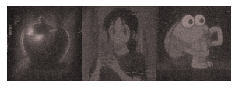

[i] Saved training sequence to /home/yz864/4197/outputs/example/optimisation.gif
440.397600142161  ms per iteration on average


In [ ]:
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm 
import imageio 

plt.ioff()
_fig, _ax = plt.subplots(figsize=(4, 4))
_img_handle   = None
_disp_handle  = None

gif_path   = join(output_dir, 'optimisation.gif')
gif_writer = imageio.get_writer(gif_path, mode='I', fps=10, loop=0)

import time
start_time = time.time()
mi.set_log_level(mi.LogLevel.Warn)
iterations = config['max_iterations']
loss_values = []
spp = config['spp']
mi.set_variant('cuda_ad_rgb')

for it in tqdm(range(iterations), desc='Optimising', ncols=0):
    t0 = time.time()

    # Apply displacement and update the scene BHV accordingly
    apply_displacement()

    # Render all 3 views
    imgs = []
    for cam in (s0, s1, s2):
        img_i = mi.render(scene, params,
                          sensor=cam,
                          seed=it,
                          spp=2 * spp, spp_grad=spp)
        imgs.append(img_i)

    # ---------- GIF frame (every iteration) ----------------------------------
    rgb8_0 = (np.clip(np.sqrt(imgs[0].numpy()), 0.0, 1.0) * 255).astype(np.uint8)
    rgb8_1 = (np.clip(np.sqrt(imgs[1].numpy()), 0.0, 1.0) * 255).astype(np.uint8)
    rgb8_2 = (np.clip(np.sqrt(imgs[2].numpy()), 0.0, 1.0) * 255).astype(np.uint8)
    rgb8   = np.hstack([rgb8_0, rgb8_1, rgb8_2])
    gif_writer.append_data(rgb8)
    # -------------------------------------------------------------------------

    # Scale-independent loss over each view
    loss0 = scale_independent_loss(imgs[0], refs[0])
    loss1 = scale_independent_loss(imgs[1], refs[1])
    loss2 = scale_independent_loss(imgs[2], refs[2])

    if it % 3 == 0:
        loss = loss0
    elif it % 3 == 1:
        loss = loss1
    else:
        loss = loss2


    # Back-propagate errors to input parameters and take an optimizer step
    dr.backward(loss)
    opt.step()

    # Increase resolution of the heightmap
    if it in upsampling_steps:
        opt['data'] = dr.upsample(opt['data'], scale_factor=(2, 2, 1))

    # Carry over the update to our "latent variable" (the heightmap values)
    params.update(opt)

    # Log progress
    elapsed_ms   = 1000. * (time.time() - t0)
    current_loss = loss.array[0]
    loss_values.append(current_loss)
    mi.Thread.thread().logger().log_progress(
        it / (iterations-1),
        f'Iteration {it:03d}: loss={current_loss:g} (took {elapsed_ms:.0f}ms)',
        'Caustic Optimization', ''
    )

    # Increase rendering quality toward the end of the optimization
    if it in (int(0.7 * iterations), int(0.9 * iterations)):
        spp *= 2
        opt.set_learning_rate(0.5 * opt.lr['data'])

    # Live preview every 10 iterations
    if it % 10 == 0:
        if _img_handle is None:
            _img_handle = _ax.imshow(rgb8, interpolation='nearest')
            _ax.axis('off')
            _disp_handle = display(_fig, display_id=True)
        else:
            _img_handle.set_data(rgb8)
            _disp_handle.update(_fig)

end_time = time.time()
plt.close(_fig)    # clean-up the figure so the notebook shows only the final frame

gif_writer.close()
print(f'[i] Saved training sequence to {gif_path}')
print(((end_time - start_time) * 1000) / iterations, ' ms per iteration on average')
mi.set_log_level(mi.LogLevel.Info)


## Saving the heighmap and the displaced mesh

In [3]:
# --- Save final heightmap and displaced mesh ---
mi.set_log_level(mi.LogLevel.Error)

fname = join(output_dir, 'heightmap_final.exr')
mi.util.write_bitmap(fname, params['data'])
print('[+] Saved final heightmap state to:', os.path.basename(fname))

fname = join(output_dir, 'lens_displaced.ply')
apply_displacement()
lens_mesh = [m for m in scene.shapes() if m.id() == 'lens'][0]
lens_mesh.write_ply(fname)
print('[+] Saved displaced lens to:', os.path.basename(fname))

[+] Saved final heightmap state to: heightmap_final.exr
[+] Saved displaced lens to: lens_displaced.ply


## Plot all three project images after training

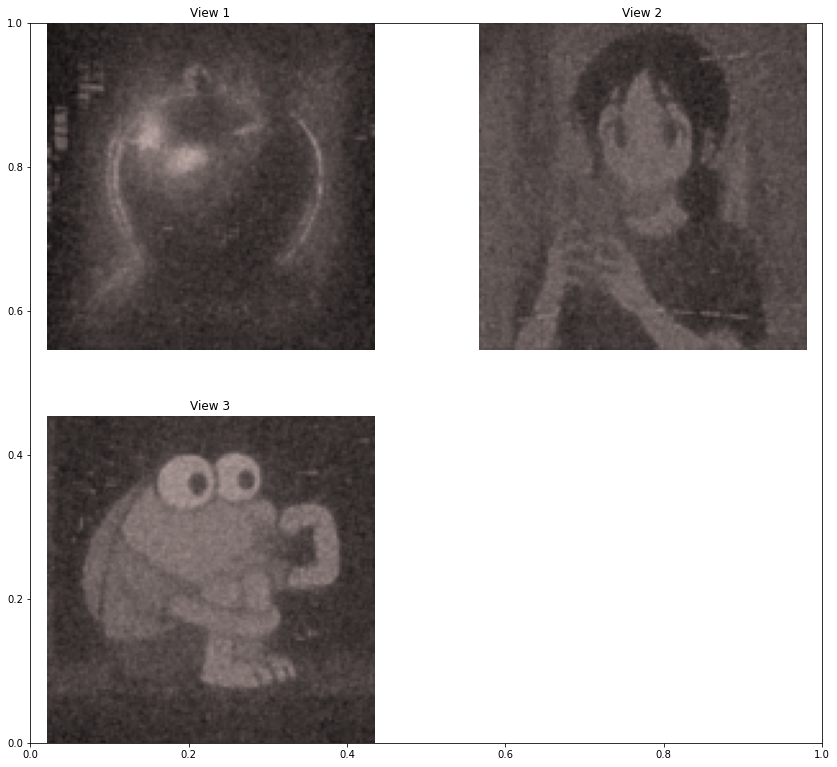

In [4]:
import matplotlib.pyplot as plt

def show_image(ax, img):
    ax.imshow(mi.util.convert_to_bitmap(img))
    ax.axis('off')

fig, ax = plt.subplots(figsize=(11, 10))
for i, img in enumerate(imgs):
    ax = fig.add_subplot(2, 2, i + 1)
    show_image(ax, img)
    ax.set_title(f'View {i+1}')

plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

plt.show()


## Build the final scene with the lamp in the center of the room

In [ ]:
import os
from os.path import realpath, join

import drjit as dr
import mitsuba as mi

# mi.set_variant('llvm_ad_rgb')
mi.set_variant('cuda_ad_rgb')

SCENE_DIR = realpath('/home/yz864/4197/scenes')

CONFIGS = {
    'example': {
        'emitter': 'bayer',
        'reference': join(SCENE_DIR, 'references/apple.png'),
    },
}


# Pick one of the available configurations.
config_name = 'example'
config = CONFIGS[config_name]

config.update({
    'render_resolution': (128, 128),
    'heightmap_resolution': (512, 512),
    'n_upsampling_steps': 4,
    'spp': 32,
    'max_iterations': 5000,
    'learning_rate': 3e-5,
})

emitter = None
if config['emitter'] == 'gray':
    emitter = {
        'type':'directionalarea',
        'radiance': {
            'type': 'spectrum',
            'value': 0.8
        },
    }
elif config['emitter'] == 'bayer':
    bayer = dr.zeros(mi.TensorXf, (32, 32, 3))
    bayer[ ::2,  ::2, 2] = 2.2
    bayer[ ::2, 1::2, 1] = 2.2
    bayer[1::2, 1::2, 0] = 2.2

    emitter = {
        'type':'directionalarea',
        'radiance': {
            'type': 'bitmap',
            'bitmap': mi.Bitmap(bayer),
            'raw': True,
            'filter_type': 'nearest'
        },
    }

integrator = {
    'type': 'ptracer',
    'max_depth': 16
}

integrator_path = {
    'type': 'aov',
    'aovs': 'dd.y:depth,nn:sh_normal',
    'my_image': {
        'type': 'path',
    }
}

sensor_to_world = mi.ScalarTransform4f().look_at(
    target=[0, -20, 0],
    origin=[0, -4.65, 0],
    up=[0, 0, 1]
)
resx, resy = config['render_resolution']
sensor = {
    'type': 'perspective',
    'near_clip': 1,
    'far_clip': 1000,
    'fov': 45,
    'to_world': sensor_to_world,

    'sampler': {
        'type': 'independent',
        'sample_count': 512  # Not really used
    },
    'film': {
        'type': 'hdrfilm',
        'width': resx,
        'height': resy,
        'pixel_format': 'rgb',
        'rfilter': {
            # Important: smooth reconstruction filter with a footprint larger than 1 pixel.
            'type': 'gaussian'
        }
    },
}

move = 5

lamp_to_world = (
    mi.ScalarTransform4f()
      .rotate(axis=(1, 0, 0), angle=90)
      .translate([0, 0, move])
      .scale([0.3, 0.3, 0.3])
)

scene = {
    'type': 'scene',
    'sensor': sensor,
    'integrator': integrator,
    # Glass BSDF
    'simple-glass': {
        'type': 'dielectric',
        'id': 'simple-glass-bsdf',
        'ext_ior': 'air',
        'int_ior': 1.5,
        'specular_reflectance': { 'type': 'spectrum', 'value': 0 },
    },
    'white-bsdf': {
        'type': 'diffuse',
        'id': 'white-bsdf',
        'reflectance': { 'type': 'rgb', 'value': (1, 1, 1) },
    },
    'pink-bsdf': {
        'type': 'diffuse',
        'id': 'pink-bsdf',
        'reflectance': { 'type': 'rgb', 'value': (1, 0.7, 1) },
    },
    'yellow-bsdf': {
        'type': 'diffuse',
        'id': 'yellow-bsdf',
        'reflectance': { 'type': 'rgb', 'value': (1, 1, 0) },
    },
    'grey-bsdf': {
        'type': 'diffuse',
        'id': 'grey-bsdf',
        'reflectance': { 'type': 'rgb', 'value': (0.5, 0.5, 0.5) },
    },
    'black-bsdf': {
        'type': 'diffuse',
        'id': 'black-bsdf',
        'reflectance': { 'type': 'spectrum', 'value': 0 },
    },
    # Receiving plane
    'receiving-plane':{
        'type':'obj','id':'receiving-plane',
        'filename':'/home/yz864/4197/scenes/meshes/rectangle.obj',
        'to_world':mi.ScalarTransform4f().look_at(
            target=[0,1,0],origin=[0,-7,0],up=[0,0,1]
        ).scale((5,5,5)),
        'bsdf':{'type':'ref','id':'white-bsdf'},
    },

    # floor
    'floor': {
        'type': 'obj',
        'id': 'floor',
        'filename': '/home/yz864/4197/scenes/meshes/rectangle.obj',
        'to_world': \
            mi.ScalarTransform4f().look_at(
                target=[0, -7, 0],
                origin=[0, -7, -1.5],
                up=[0, 1, 0]
            ).scale((5, 5, 5)),
        'bsdf': {'type': 'ref', 'id': 'white-bsdf'},
    },

    # Right wall
    'rightwall': {
        'type': 'obj',
        'id': 'rightwall',
        'filename': '/home/yz864/4197/scenes/meshes/rectangle.obj',
        'to_world': \
            mi.ScalarTransform4f().look_at(
                target=[0, -7, 0],
                origin=[-1.5, -7, 0],
                up=[0, 0, 1]
            ).scale((5, 5, 5)),
        'bsdf': {'type': 'ref', 'id': 'pink-bsdf'},
    },

    # Left wall
    'leftwall': {
        'type': 'obj',
        'id': 'leftwall',
        'filename': '/home/yz864/4197/scenes/meshes/rectangle.obj',
        'to_world': \
            mi.ScalarTransform4f().look_at(
                target=[0, -7, 0],
                origin=[1.5, -7, 0],
                up=[0, 0, 1]
            ).scale((5, 5, 5)),
        'bsdf': {'type': 'ref', 'id': 'yellow-bsdf'},
    },

    # Top light
    'toplight': {
        'type': 'obj',
        'id': 'toplight',
        'filename': '/home/yz864/4197/scenes/meshes/rectangle.obj',
        'to_world': \
            mi.ScalarTransform4f().look_at(
                target=[0, -5, 0],
                origin=[0, -5, 2.5],
                up=[0, 1, 0]
            ).scale((2, 2, 2)),
        'bsdf': {'type': 'ref', 'id': 'white-bsdf'},
      'emitter': {
        'type': 'area',
        'radiance': {
            'type': 'rgb',
            'value': [0.1, 0.1, 0.1]
        }
    }
    },

    'slab':{
        'type':'obj','id':'slab',
        'filename':'/home/yz864/4197/scenes/meshes/lamp.obj',
        'to_world':lamp_to_world,
        'bsdf':{'type':'ref','id':'simple-glass'},
    },
    
    'base':{
        'type':'obj','id':'base',
        'filename':'/home/yz864/4197/scenes/meshes/lamp_base.obj',
        'to_world':(
            mi.ScalarTransform4f()
            .rotate(axis=(1, 0, 0), angle=90)
        ),
        'bsdf':{'type':'ref','id':'grey-bsdf'},
        'face_normals': False,
        'flip_normals': True,
    },
    'lens':{
        'type':'ply','id':'lens','filename':"/home/yz864/4197/outputs/example/lens_displaced.ply",
        'to_world':    mi.ScalarTransform4f(),
        'bsdf':{'type':'ref','id':'simple-glass'},
    },
    'point-light':{
        'type':'point',
        'to_world':lamp_to_world,
        'intensity':{'type':'spectrum','value':2},
    },
    # 'global-light': {
    #     'type': 'constant',
    #     'radiance': {
    #         'type': 'rgb',
    #         'value': 0.3,
    #     }
    # },

}

scene = mi.load_dict(scene)

## Render the final scene

/tmp/ipykernel_747521/863356402.py:46: DeprecationWarning: clamp() is deprecated, please use clip(...)
  side_image = dr.clamp(side_image, 0, 1)


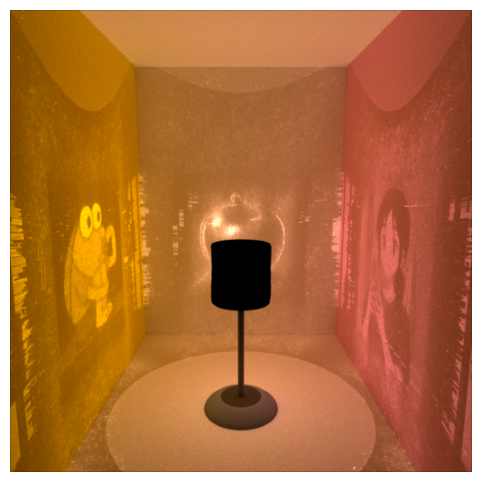

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# mi.set_variant('llvm_ad_rgb')
mi.set_variant('cuda_ad_rgb')

side_sensor_dict = {
    'type': 'perspective',
    'fov': 60,
    # 'to_world': mi.ScalarTransform4f().look_at(
    #     # x increases = left
    #     # x increases = further
    #     origin=[4, 4, 8],  # side + slightly above
    #     target=[0, 0, 0],   # aim at the world origin
    #     up=[0, 0, 1]
    # ),

    'to_world': mi.ScalarTransform4f().look_at(
        # x increases = left
        # y increases = further
        origin=[0, -1, 1],
        target=[0, -7, 0],
        up=[0, 0, 1]
    ),

    'film': {
        'type': 'hdrfilm',
        'width': 512,
        'height': 512,
        'pixel_format': 'rgb',
        'rfilter': {
            'type': 'gaussian'
        }
    },
    'sampler': {
        'type': 'independent',
        'sample_count': 1024
    }

}

side_sensor = mi.load_dict(side_sensor_dict)

side_image = mi.render(scene, sensor=side_sensor, seed=0)

side_image = dr.clamp(side_image, 0, 1)

plt.figure(figsize=(6,6))
plt.imshow(np.array(side_image))
plt.axis('off')
plt.show()
